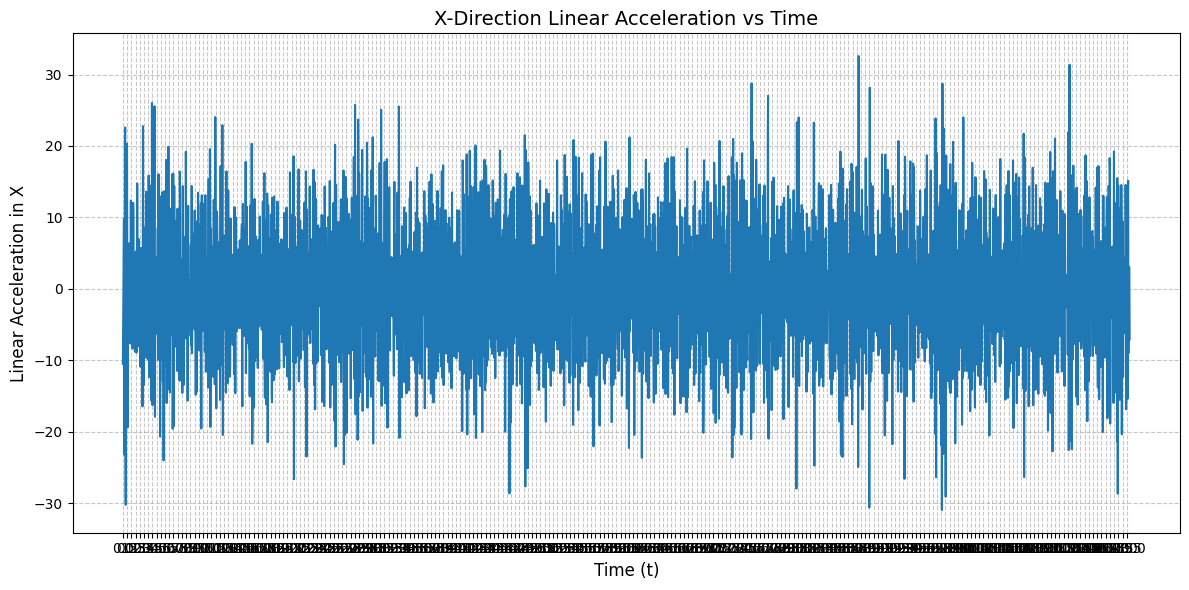

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

# Load YAML data
with open('data/imu.yaml', 'r') as file:
    yaml_data = yaml.safe_load(file)  # Proper YAML loading

# Extract and flatten the nested list structure
raw_values = np.array(yaml_data['data']).flatten()  # Handle nested lists

# Reshape into t,x,y,z columns with validation
try:
    data = raw_values.reshape(-1, 4)  # Force 4-column structure
except ValueError:
    print(f"Data length {len(raw_values)} not divisible by 4")
    raise

t = data[:, 0]  # First column is time
x = data[:, 1]  # Second column is x-position

# Calculate linear acceleration using numerical differentiation
dx_dt = np.gradient(x, t)  # First derivative (velocity)
d2x_dt2 = np.gradient(dx_dt, t)  # Second derivative (acceleration)
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(t, d2x_dt2)
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Linear Acceleration in X', fontsize=12)
plt.title('X-Direction Linear Acceleration vs Time', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Customize ticks and layout
plt.xticks(np.arange(min(t), max(t)+0.1, step=0.5))
plt.tight_layout()
plt.show()


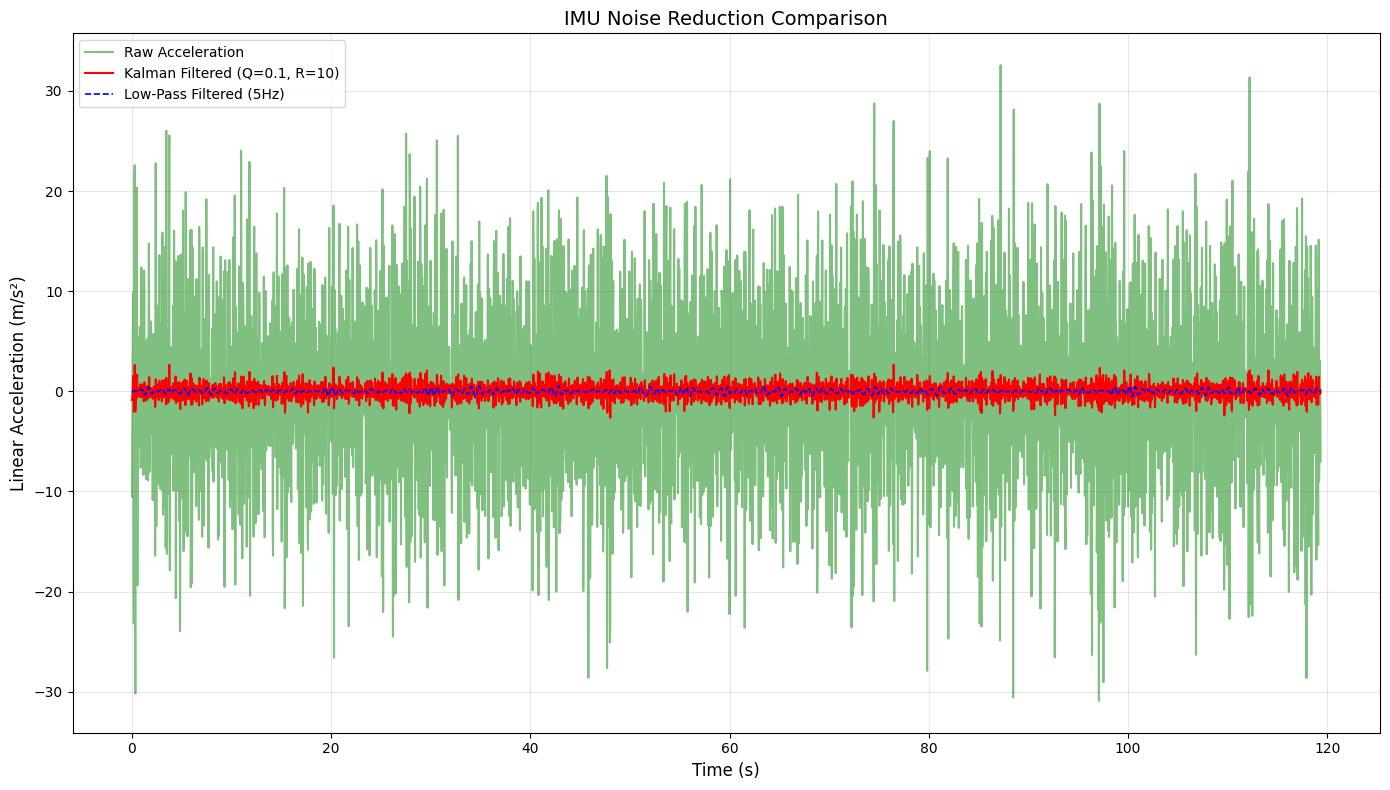

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def kalman_filter(measurements, Q=0.1, R=10):
    """Kalman filter implementation based on sensor noise characteristics"""
    n = len(measurements)
    estimates = np.zeros(n)
    P = np.zeros(n)
    estimates[0] = measurements[0]
    P[0] = 1.0
    
    for k in range(1, n):
        # Prediction
        x_pred = estimates[k-1]
        P_pred = P[k-1] + Q
        
        # Update
        K = P_pred / (P_pred + R)
        estimates[k] = x_pred + K * (measurements[k] - x_pred)
        P[k] = (1 - K) * P_pred
        
    return estimates

def lowpass_filter(data, cutoff=5, fs=100, order=4):
    """Butterworth low-pass filter for IMU noise reduction"""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Load and process data
with open('file.yaml', 'r') as file:
    raw_data = yaml.safe_load(file)
data = np.array(raw_data['data']).flatten().reshape(-1, 4)
t, x, y, z = data.T

# Apply filters to X-axis data (repeat for Y/Z as needed)
x_kalman = kalman_filter(x, Q=0.1, R=10)  # Recommended ratio 100
x_lowpass = lowpass_filter(x, cutoff=5)    # 5Hz cutoff for body motion

# Calculate acceleration from filtered data
dt = np.gradient(t)
dx_kalman = np.gradient(x_kalman, t)
accel_kalman = np.gradient(dx_kalman, t)

dx_lowpass = np.gradient(x_lowpass, t)
accel_lowpass = np.gradient(dx_lowpass, t)

# Plot comparison
plt.figure(figsize=(14, 8))
plt.plot(t, np.gradient(np.gradient(x, t), t), 'g-', alpha=0.5, label='Raw Acceleration')
plt.plot(t, accel_kalman, 'r-', linewidth=1.5, label='Kalman Filtered (Q=0.1, R=10)')
plt.plot(t, accel_lowpass, 'b--', linewidth=1.2, label='Low-Pass Filtered (5Hz)')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Linear Acceleration (m/s²)', fontsize=12)
plt.title('IMU Noise Reduction Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\Michael Gross\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\pyplot.py'>

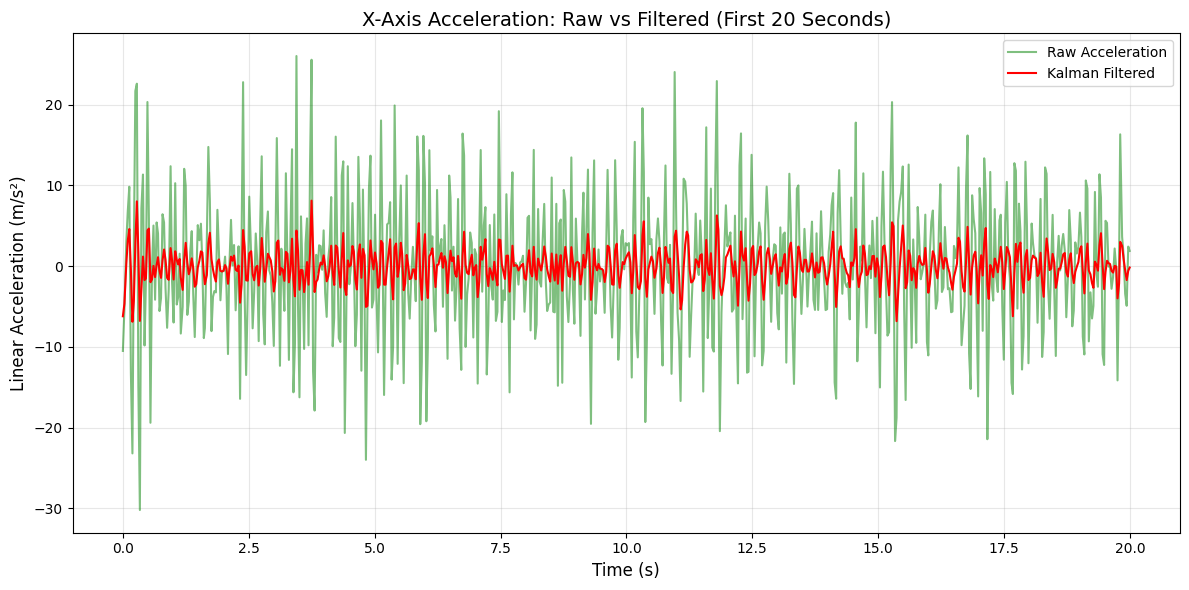

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

def kalman_filter(data, Q=0.01, R=0.1):
    """Simplified Kalman filter implementation for IMU data"""
    n = len(data)
    estimates = np.zeros(n)
    P = np.zeros(n)
    estimates[0] = data[0]
    P[0] = 1.0
    
    for k in range(1, n):
        # Prediction
        x_pred = estimates[k-1]
        P_pred = P[k-1] + Q
        
        # Update
        K = P_pred / (P_pred + R)
        estimates[k] = x_pred + K * (data[k] - x_pred)
        P[k] = (1 - K) * P_pred
        
    return estimates

# Load and process YAML data
with open('file.yaml', 'r') as file:
    yaml_data = yaml.safe_load(file)

# Extract and flatten nested lists
raw_values = np.array([item for sublist in yaml_data['data'] for item in sublist])

# Reshape into t,x,y,z columns and select first 20 seconds
data = raw_values.reshape(-1, 4)
t = data[:, 0]
mask = t <= 20
t_20s = t[mask]
x_20s = data[mask, 1]

# Calculate raw acceleration
dx = np.gradient(x_20s, t_20s)
raw_accel = np.gradient(dx, t_20s)

# Apply Kalman filter to x-axis data
filtered_x = kalman_filter(x_20s)
dfdx = np.gradient(filtered_x, t_20s)
filtered_accel = np.gradient(dfdx, t_20s)

# Create results dictionary
results = {
    'time': t_20s,
    'raw': {
        'position': x_20s,
        'acceleration': raw_accel
    },
    'filtered': {
        'position': filtered_x,
        'acceleration': filtered_accel
    }
}

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(results['time'], results['raw']['acceleration'], 
        'g-', alpha=0.5, label='Raw Acceleration')
plt.plot(results['time'], results['filtered']['acceleration'], 
        'r-', linewidth=1.5, label='Kalman Filtered')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Linear Acceleration (m/s²)', fontsize=12)
plt.title('X-Axis Acceleration: Raw vs Filtered (First 20 Seconds)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt


low pass fir window bartlett

Estimated sampling frequency: 33.23 Hz


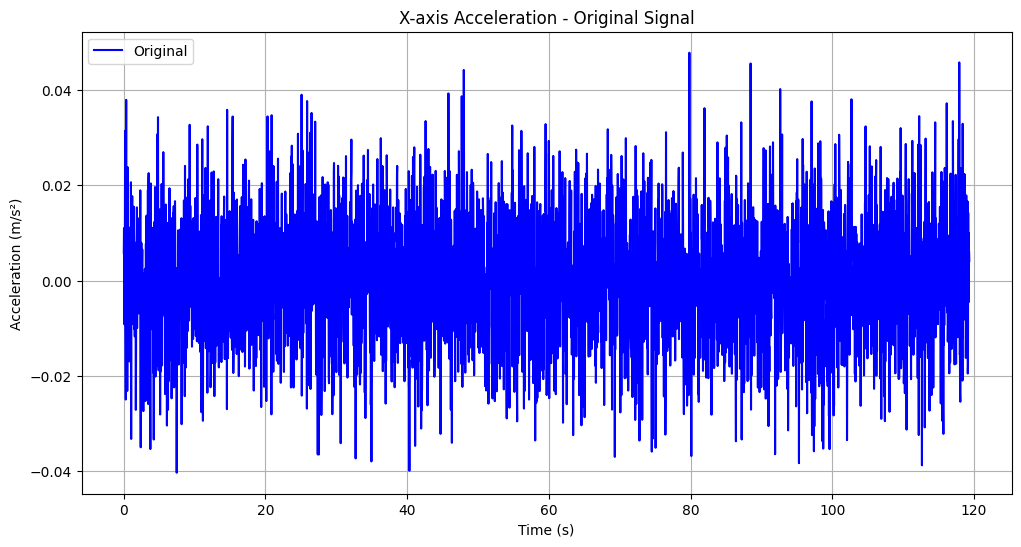

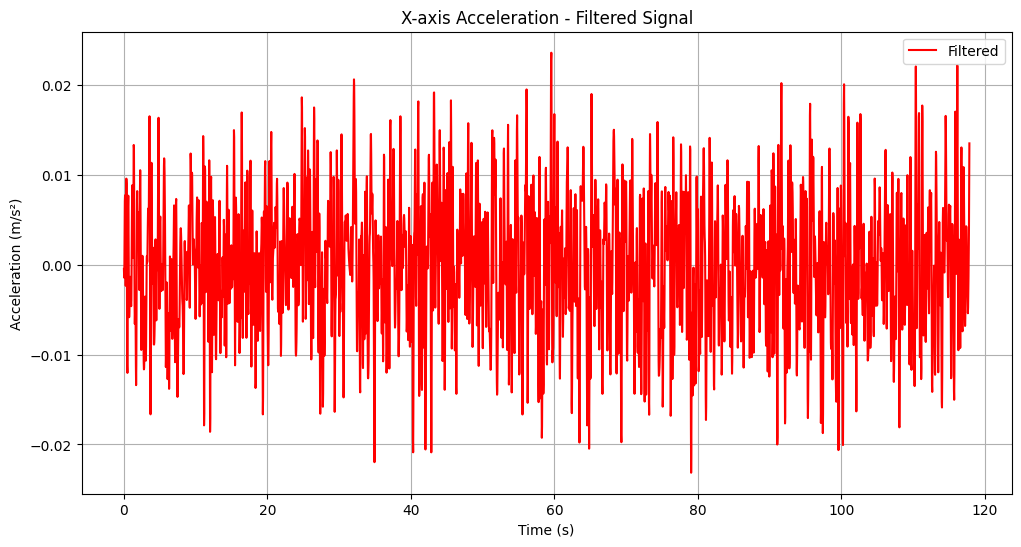

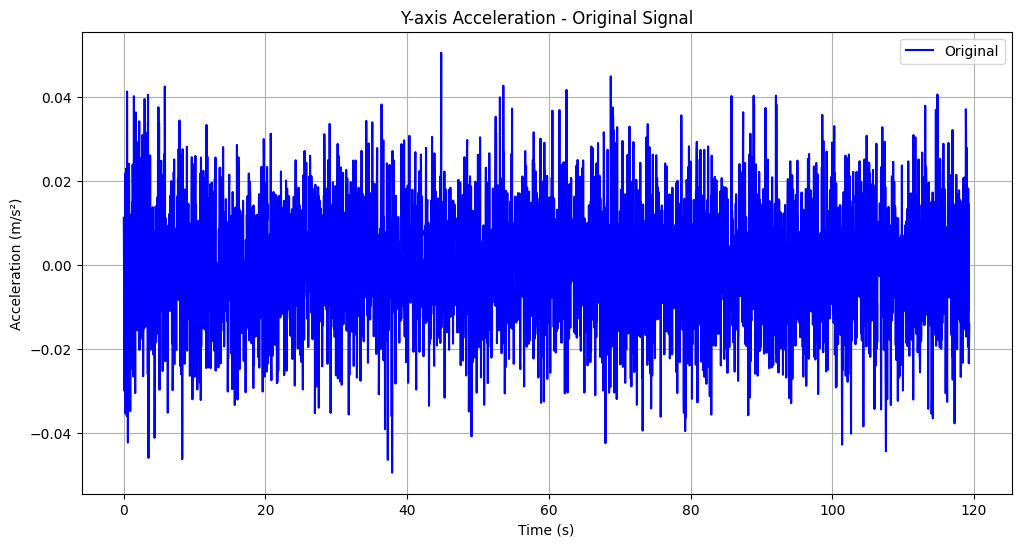

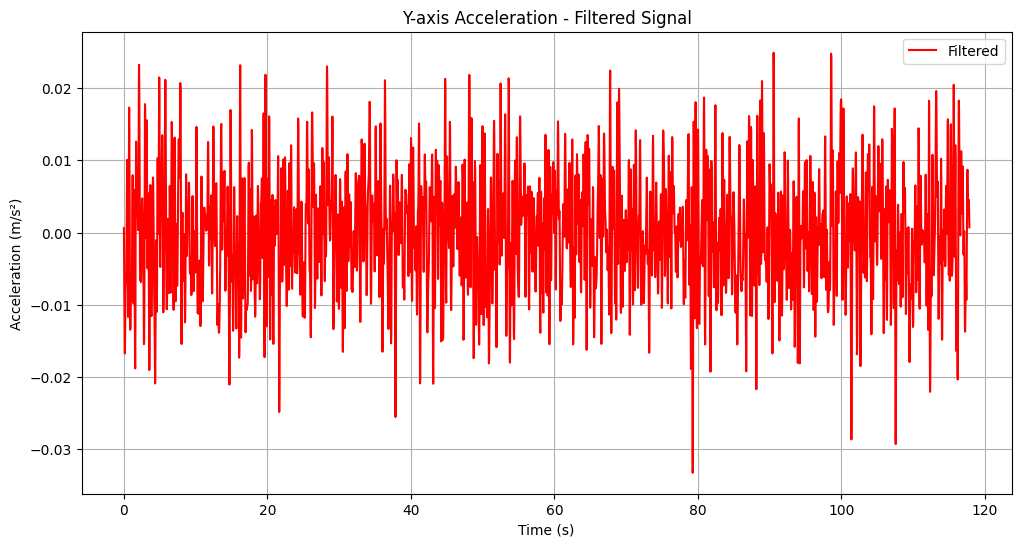

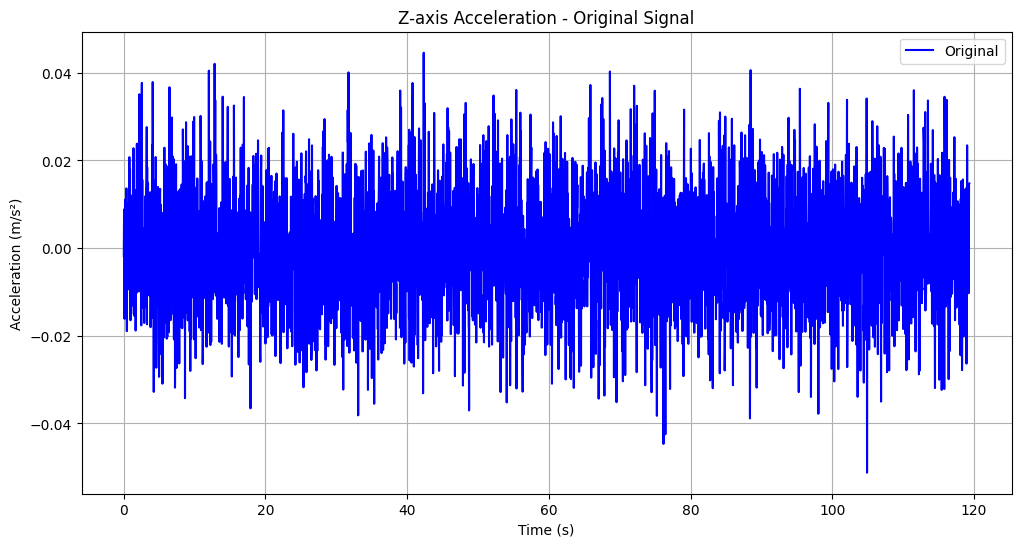

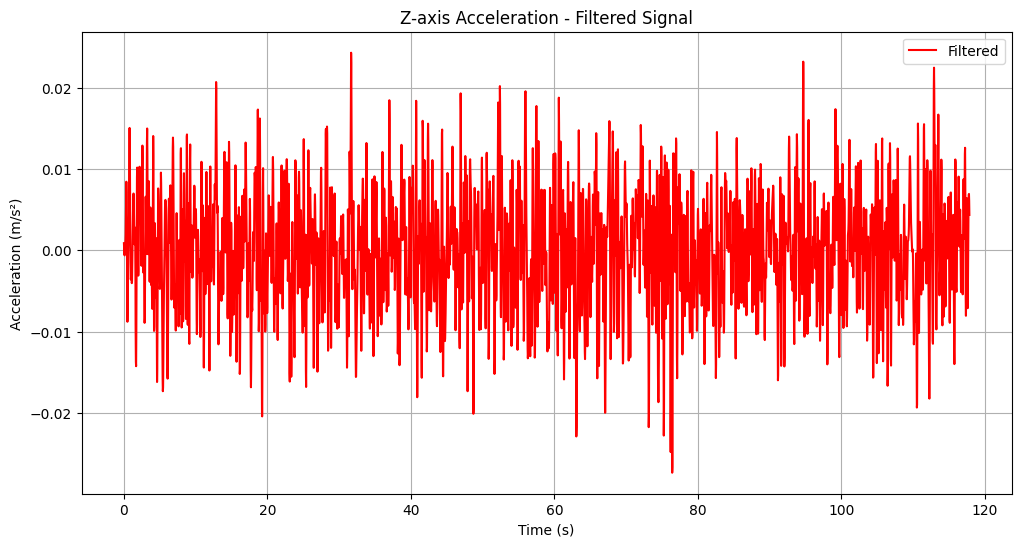

In [5]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def load_imu_data(yaml_file_path):
    """Load IMU data from YAML file"""
    with open(yaml_file_path, 'r') as file:
        data = yaml.safe_load(file)
    
    # Extract the data array
    imu_data = np.array(data['data'])
    
    # Separate into time and sensor readings
    time = imu_data[:, 0]  # First column is time
    accel_x = imu_data[:, 1]  # Second column is acceleration x
    accel_y = imu_data[:, 2]  # Third column is acceleration y
    accel_z = imu_data[:, 3]  # Fourth column is acceleration z
    
    return time, accel_x, accel_y, accel_z

def apply_fir_filter(data, numtaps=51, cutoff=0.1, fs=1.0):
    """Apply FIR lowpass filter to the data"""
    # Design the FIR filter using the Bartlett window
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    taps = signal.firwin(numtaps, normalized_cutoff, window='bartlett')  # Changed to Bartlett window
    
    # Apply the filter
    filtered_data = signal.lfilter(taps, 1.0, data)
    
    # Compensate for the delay introduced by the filter
    filtered_data = filtered_data[numtaps//2:]
    
    return filtered_data

def plot_results_separate(time, original, filtered, title, ylabel):
    """Plot original and filtered signals in separate windows"""
    # Plot original signal
    plt.figure(figsize=(12, 6))
    plt.plot(time[:len(original)], original[:len(original)], 'b-', label='Original')
    plt.title(f'{title} - Original Signal')
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot filtered signal
    plt.figure(figsize=(12, 6))
    plt.plot(time[:len(filtered)], filtered, 'r-', label='Filtered')
    plt.title(f'{title} - Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # YAML file is in the same directory as the script
    yaml_file_path = 'file.yaml'
    
    try:
        # Load IMU data
        time, accel_x, accel_y, accel_z = load_imu_data(yaml_file_path)
        
        # Estimate sampling frequency (assuming uniform sampling)
        fs = 1.0 / np.mean(np.diff(time))
        print(f"Estimated sampling frequency: {fs:.2f} Hz")
        
        # Apply FIR filter to each axis
        cutoff_freq = 5.0  # Cutoff frequency in Hz (adjust as needed)
        numtaps = 101  # Number of filter taps (higher = sharper cutoff)
        
        filtered_x = apply_fir_filter(accel_x, numtaps, cutoff_freq, fs)
        filtered_y = apply_fir_filter(accel_y, numtaps, cutoff_freq, fs)
        filtered_z = apply_fir_filter(accel_z, numtaps, cutoff_freq, fs)
        
        # Plot results in separate windows
        plot_results_separate(time, accel_x, filtered_x, 'X-axis Acceleration', 'Acceleration (m/s²)')
        plot_results_separate(time, accel_y, filtered_y, 'Y-axis Acceleration', 'Acceleration (m/s²)')
        plot_results_separate(time, accel_z, filtered_z, 'Z-axis Acceleration', 'Acceleration (m/s²)')
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()


low pass hamming window fir filter 


Estimated sampling frequency: 33.23 Hz


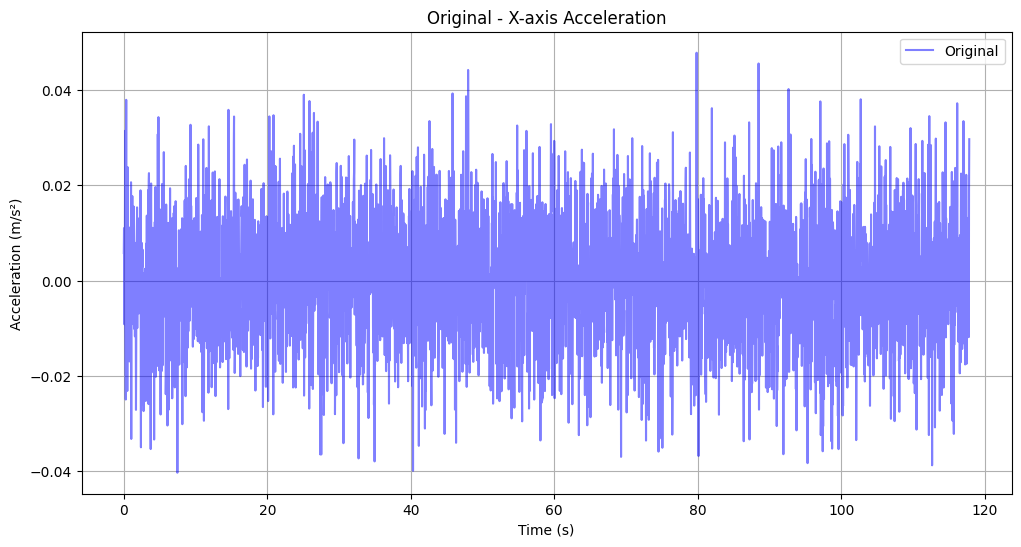

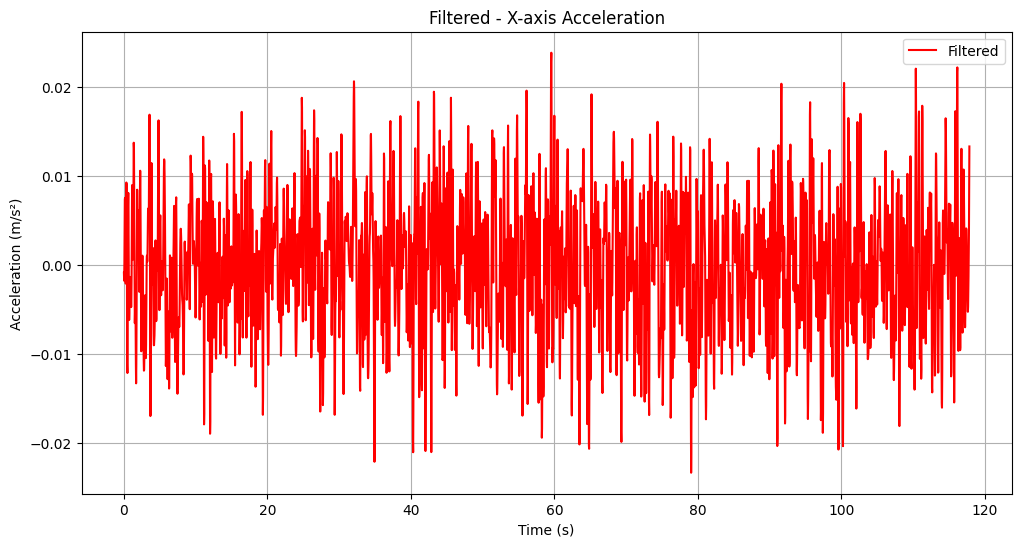

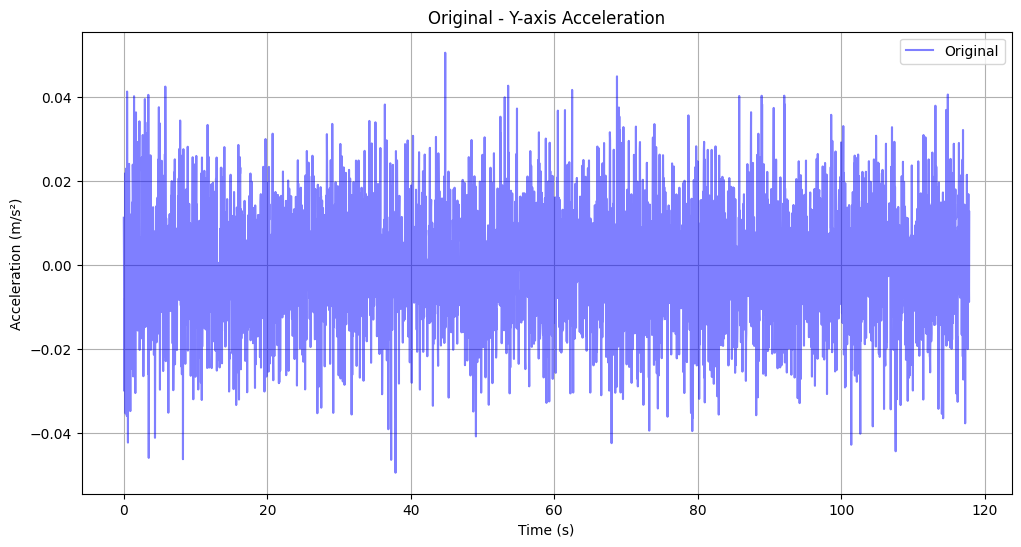

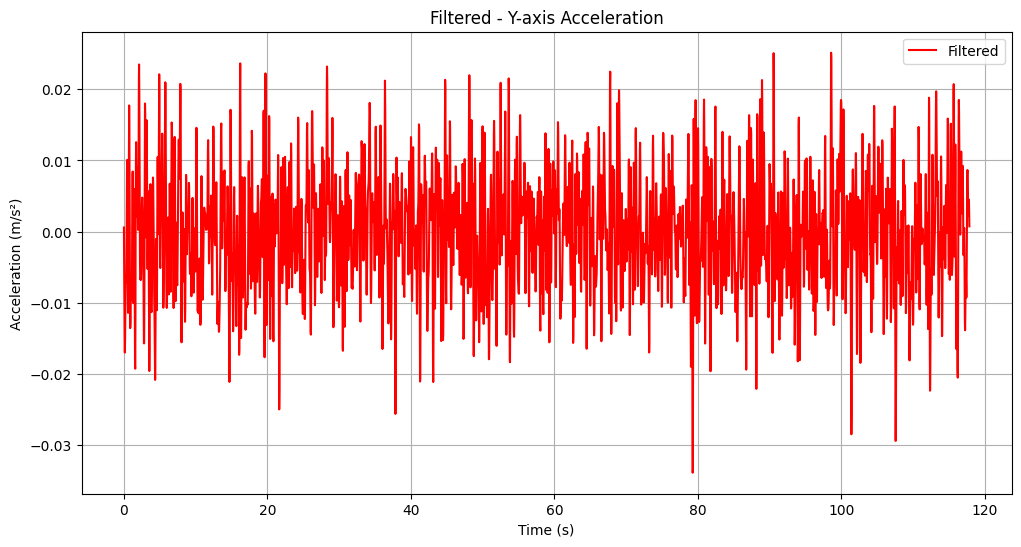

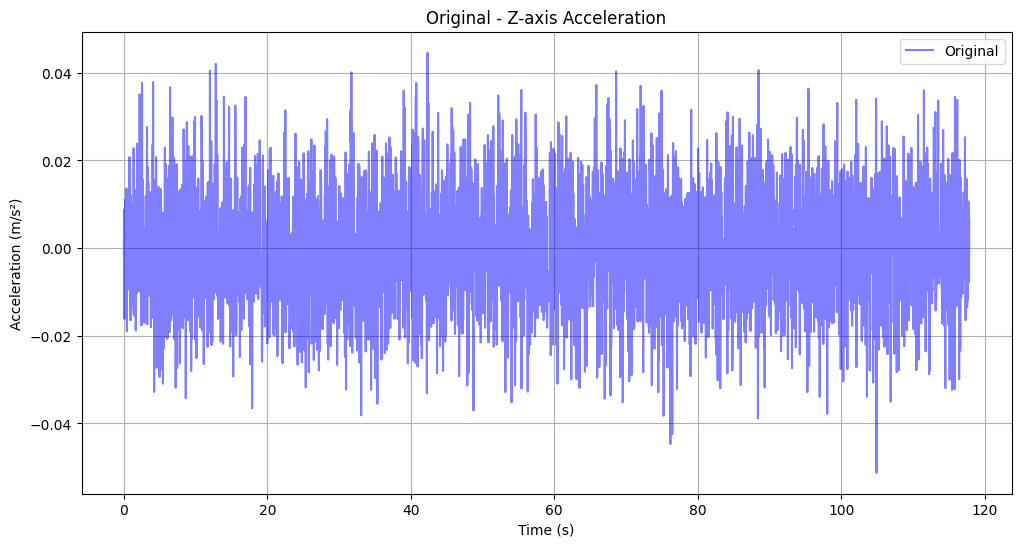

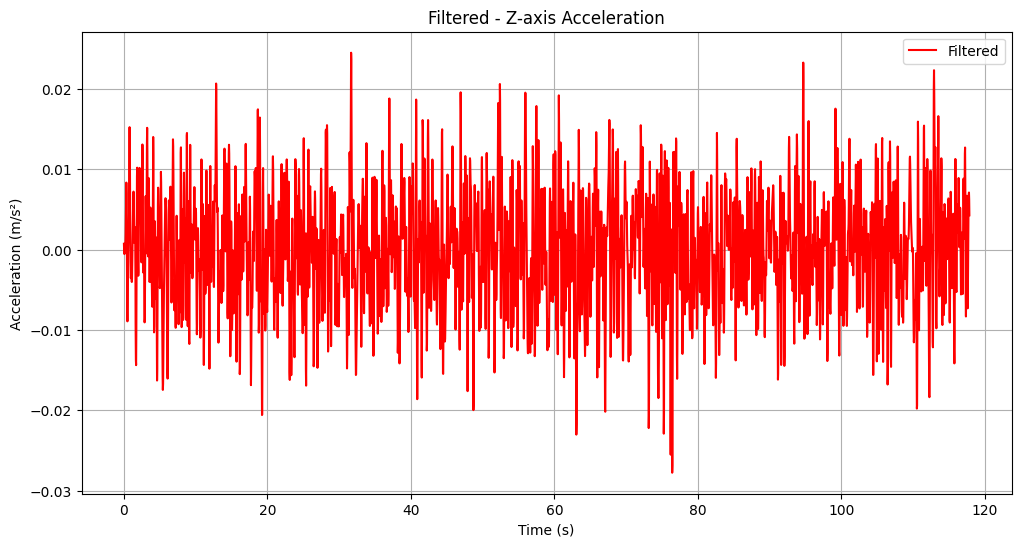

In [6]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def load_imu_data(yaml_file_path):
    """Load IMU data from YAML file"""
    with open(yaml_file_path, 'r') as file:
        data = yaml.safe_load(file)
    
    # Extract the data array
    imu_data = np.array(data['data'])
    
    # Separate into time and sensor readings
    time = imu_data[:, 0]  # First column is time
    accel_x = imu_data[:, 1]  # Second column is acceleration x
    accel_y = imu_data[:, 2]  # Third column is acceleration y
    accel_z = imu_data[:, 3]  # Fourth column is acceleration z
    
    return time, accel_x, accel_y, accel_z

def apply_fir_filter(data, numtaps=101, cutoff=0.1, fs=1.0):
    """Apply FIR lowpass filter with a Hamming window shape"""
    # Design the FIR filter using the Hamming window
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    taps = signal.firwin(numtaps, normalized_cutoff, window='hamming')
    
    # Apply the filter
    filtered_data = signal.lfilter(taps, 1.0, data)
    
    # Compensate for the delay introduced by the filter
    filtered_data = filtered_data[numtaps//2:]
    
    return filtered_data

def plot_results_separate(time, original, filtered, title, ylabel):
    """Plot original and filtered signals in separate windows"""
    # Trim the original data to match the length of the filtered data
    time_trimmed = time[:len(filtered)]  # Trim time to match filtered length
    original_trimmed = original[:len(filtered)]  # Trim original data to match filtered length
    
    # Original signal plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_trimmed, original_trimmed, 'b-', label='Original', alpha=0.5)
    plt.title(f"Original - {title}")
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Filtered signal plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_trimmed, filtered, 'r-', label='Filtered')
    plt.title(f"Filtered - {title}")
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Load the YAML file (replace with your actual file path)
    yaml_file_path = 'file.yaml'
    
    try:
        # Load IMU data
        time, accel_x, accel_y, accel_z = load_imu_data(yaml_file_path)
        
        # Estimate sampling frequency (assuming uniform sampling)
        fs = 1.0 / np.mean(np.diff(time))
        print(f"Estimated sampling frequency: {fs:.2f} Hz")
        
        # Apply FIR filter to each axis
        cutoff_freq = 5.0  # Cutoff frequency in Hz (adjust as needed)
        numtaps = 101  # Number of filter taps (higher = sharper cutoff)
        
        filtered_x = apply_fir_filter(accel_x, numtaps, cutoff_freq, fs)
        filtered_y = apply_fir_filter(accel_y, numtaps, cutoff_freq, fs)
        filtered_z = apply_fir_filter(accel_z, numtaps, cutoff_freq, fs)
        
        # Plot results (separate windows for original and filtered data)
        plot_results_separate(time, accel_x, filtered_x, 'X-axis Acceleration', 'Acceleration (m/s²)')
        plot_results_separate(time, accel_y, filtered_y, 'Y-axis Acceleration', 'Acceleration (m/s²)')
        plot_results_separate(time, accel_z, filtered_z, 'Z-axis Acceleration', 'Acceleration (m/s²)')
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()
